In [1]:
import numpy as np
import pandas as pd

import json
import re
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder, MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import export_graphviz
from sklearn.metrics import confusion_matrix 
from sklearn.utils.multiclass import unique_labels

import graphviz

In [2]:
import matplotlib
matplotlib.rcParams.update({'font.size': 15})

1. Extract data from json, same as in the EDA file

In [3]:
trainrecipts = json.load(open('recipies.json','r'))

# Quick&dirty code to extract info2list
raw_ingredients = list()

for recipt in trainrecipts:
    for ingredient in recipt[u'ingredients']:
        raw_ingredients.append(ingredient.strip())      

raw_cuisines = list()
for recipt in trainrecipts:
    raw_cuisines.append(recipt[u'cuisine'].strip())


In [4]:
## merge all the ingredients into sentences to generate WordtoVec model
sentences = list()
# one hot ingredients


for recipt in trainrecipts:
    clean_recipt = list()
    # I want ingredient remove 
    for ingredient in recipt['ingredients']:
        # remove this description from the ingredients
        # minimal preprocessing
        ingredient =  re.sub(r'\(.*oz.\)|crushed|crumbles|ground|minced|powder|chopped|sliced',
                             '', 
                             ingredient)
        clean_recipt.append(ingredient.strip())
    sentences.append(clean_recipt)
        
len(sentences)

39774

In [5]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """


    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

#     print(cm)

    fig, ax = plt.subplots(figsize = (25,25))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


## 1. Build model for manual labelling

The first request is to generate instructions for the team to manual label the major cuisine based on ingredients. In the previous EDA, we can see from the tSNE based on ingredients (converted to vector using word2vec), there are five distinct groups:  'Italian', 'Mexican', 'southern_us', 'Indian', 'Chinese'. In this task, we target only these five groups for a shallow tree model that can be used for manual labeling.

In [6]:
mlb = MultiLabelBinarizer()
X_dummy_var = mlb.fit_transform(sentences)
# convert all ingredients to dummy variables
top5_cuisine = 'italian', 'mexican', 'southern_us', 'indian', 'chinese'
y = np.asarray(raw_cuisines)

In [7]:
def select_sub_group(top5_cuisine, y, X_dummy_var):
    select_y_total = np.zeros((1))
    select_x_total = np.zeros((1, np.shape(X_dummy_var)[1]))

    for i in range(len(top5_cuisine)):
        index = np.where(y==top5_cuisine[i])
        select_y = y[index]
        select_x = X_dummy_var[index]
        select_y_total = np.hstack((select_y,select_y_total))
        select_x_total = np.vstack((select_x,select_x_total))
        
    return(select_x_total[1:,:], select_y_total[1:])

In [8]:
select_x_total, select_y_total = select_sub_group(top5_cuisine, y, X_dummy_var)

In [9]:
def select_depth(select_x_total,select_y_total):
    X_train, X_test, y_train, y_test = \
    train_test_split(select_x_total, select_y_total, test_size=0.33, random_state=42)
    train_score = []
    test_score = []
    for n in range(5,15):
        clf = tree.DecisionTreeClassifier(max_depth=n,max_leaf_nodes =9)
        clf = clf.fit(X_train, y_train) 
        train_score.append(clf.score(X_train, y_train))
        test_score.append(clf.score(X_test, y_test))
#         print(train_score,test_score)
    return(train_score,test_score)

Check the score as the depth increase for the tree

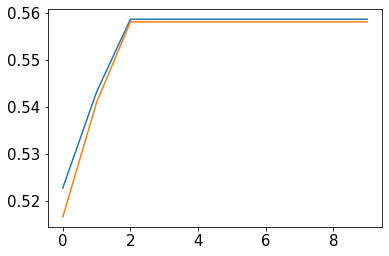

In [10]:
train_score,test_score = select_depth(select_x_total,select_y_total)

plt.plot(train_score)
plt.plot(test_score)

The accuracy stop to increase after the 2nd iteration, which correspond to the tree depth 2 + 5 =7

In [11]:
clf = tree.DecisionTreeClassifier(max_depth=7, max_leaf_nodes =9)
clf = clf.fit(select_x_total,select_y_total) 
print('score:,',clf.score(select_x_total,select_y_total))

score:, 0.5527768622280818


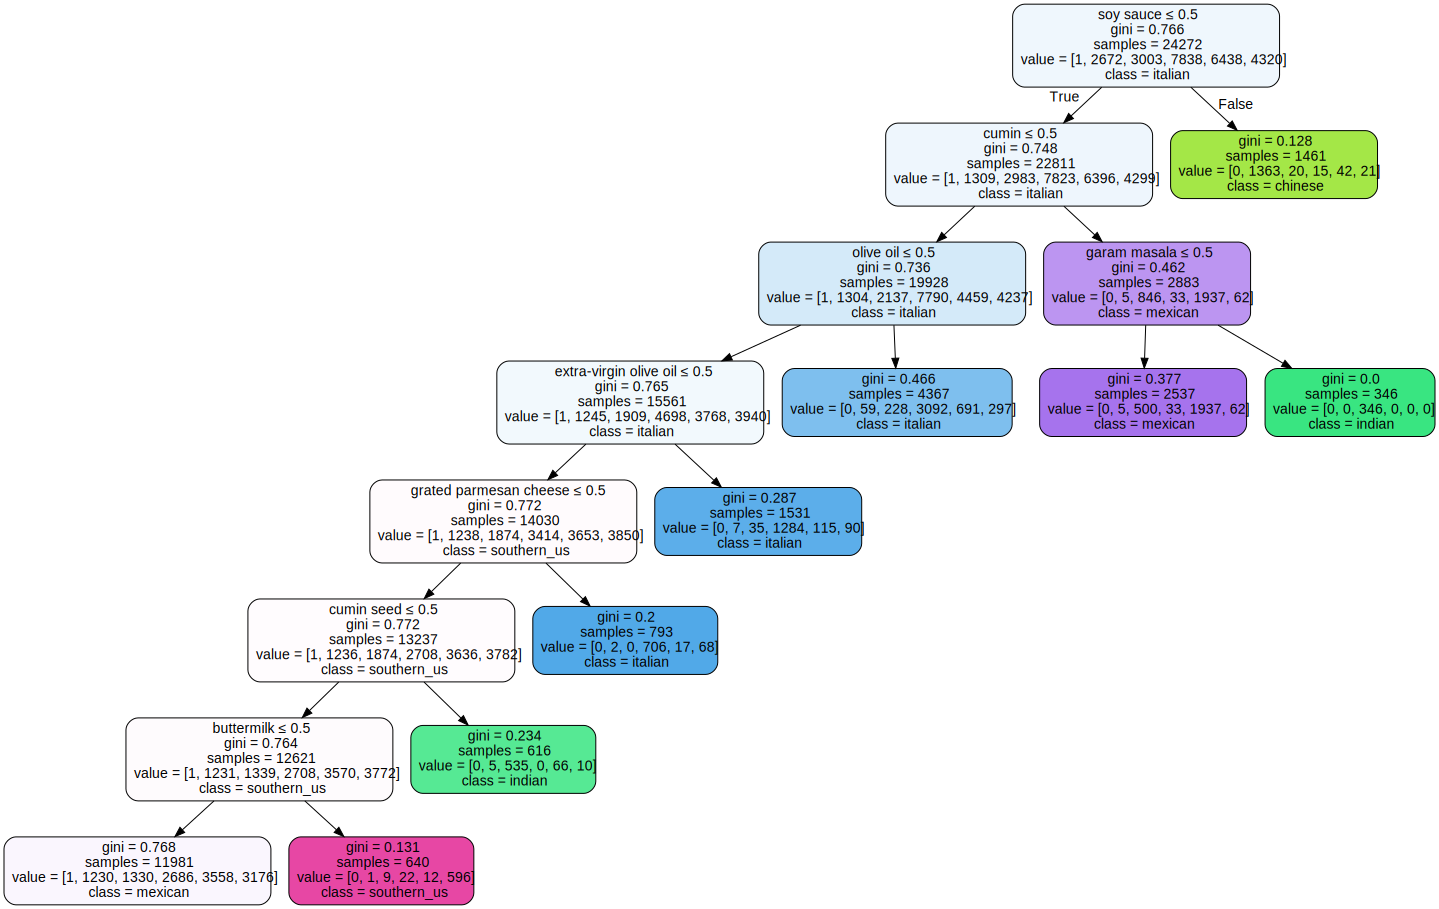

In [12]:
dot_data = tree.export_graphviz(clf, out_file=None, 
                      feature_names=mlb.classes_,  
                      class_names=np.unique(select_y_total),  
                      filled=True, rounded=True,  
                      special_characters=True)  

graph = graphviz.Source(dot_data)  

graph

In [13]:
graph.render('test-output/food.gv', view=True)   # save the graph as guidance for manual labeling

'test-output/food.gv.pdf'

## 2. Use random forest to build base line model for cuisine prediction based on ingredients

In [14]:
y = raw_cuisines
np.shape(y)
le = LabelEncoder()
le.fit(y)

y_cat = le.transform(y) 
# convert y (cuisine to categorical data)

dummy_label_col = list(mlb.classes_)
dummy_label_col = pd.DataFrame(columns=dummy_label_col)
# keep the dummy variable converting table to convert back the ingredients 

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X_dummy_var, y_cat, test_size=0.33, random_state=42)

In [16]:
# Model (can also use single decision tree)
model = RandomForestClassifier(n_estimators=10)
# Train
model.fit(X_train, y_train)
# Extract single tree

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [17]:
model.score(X_train,y_train)

0.9917066946862804

In [18]:
model.score(X_test,y_test)

0.6592259637360963

In [19]:
y_pred = model.predict(X_test)

Normalized confusion matrix


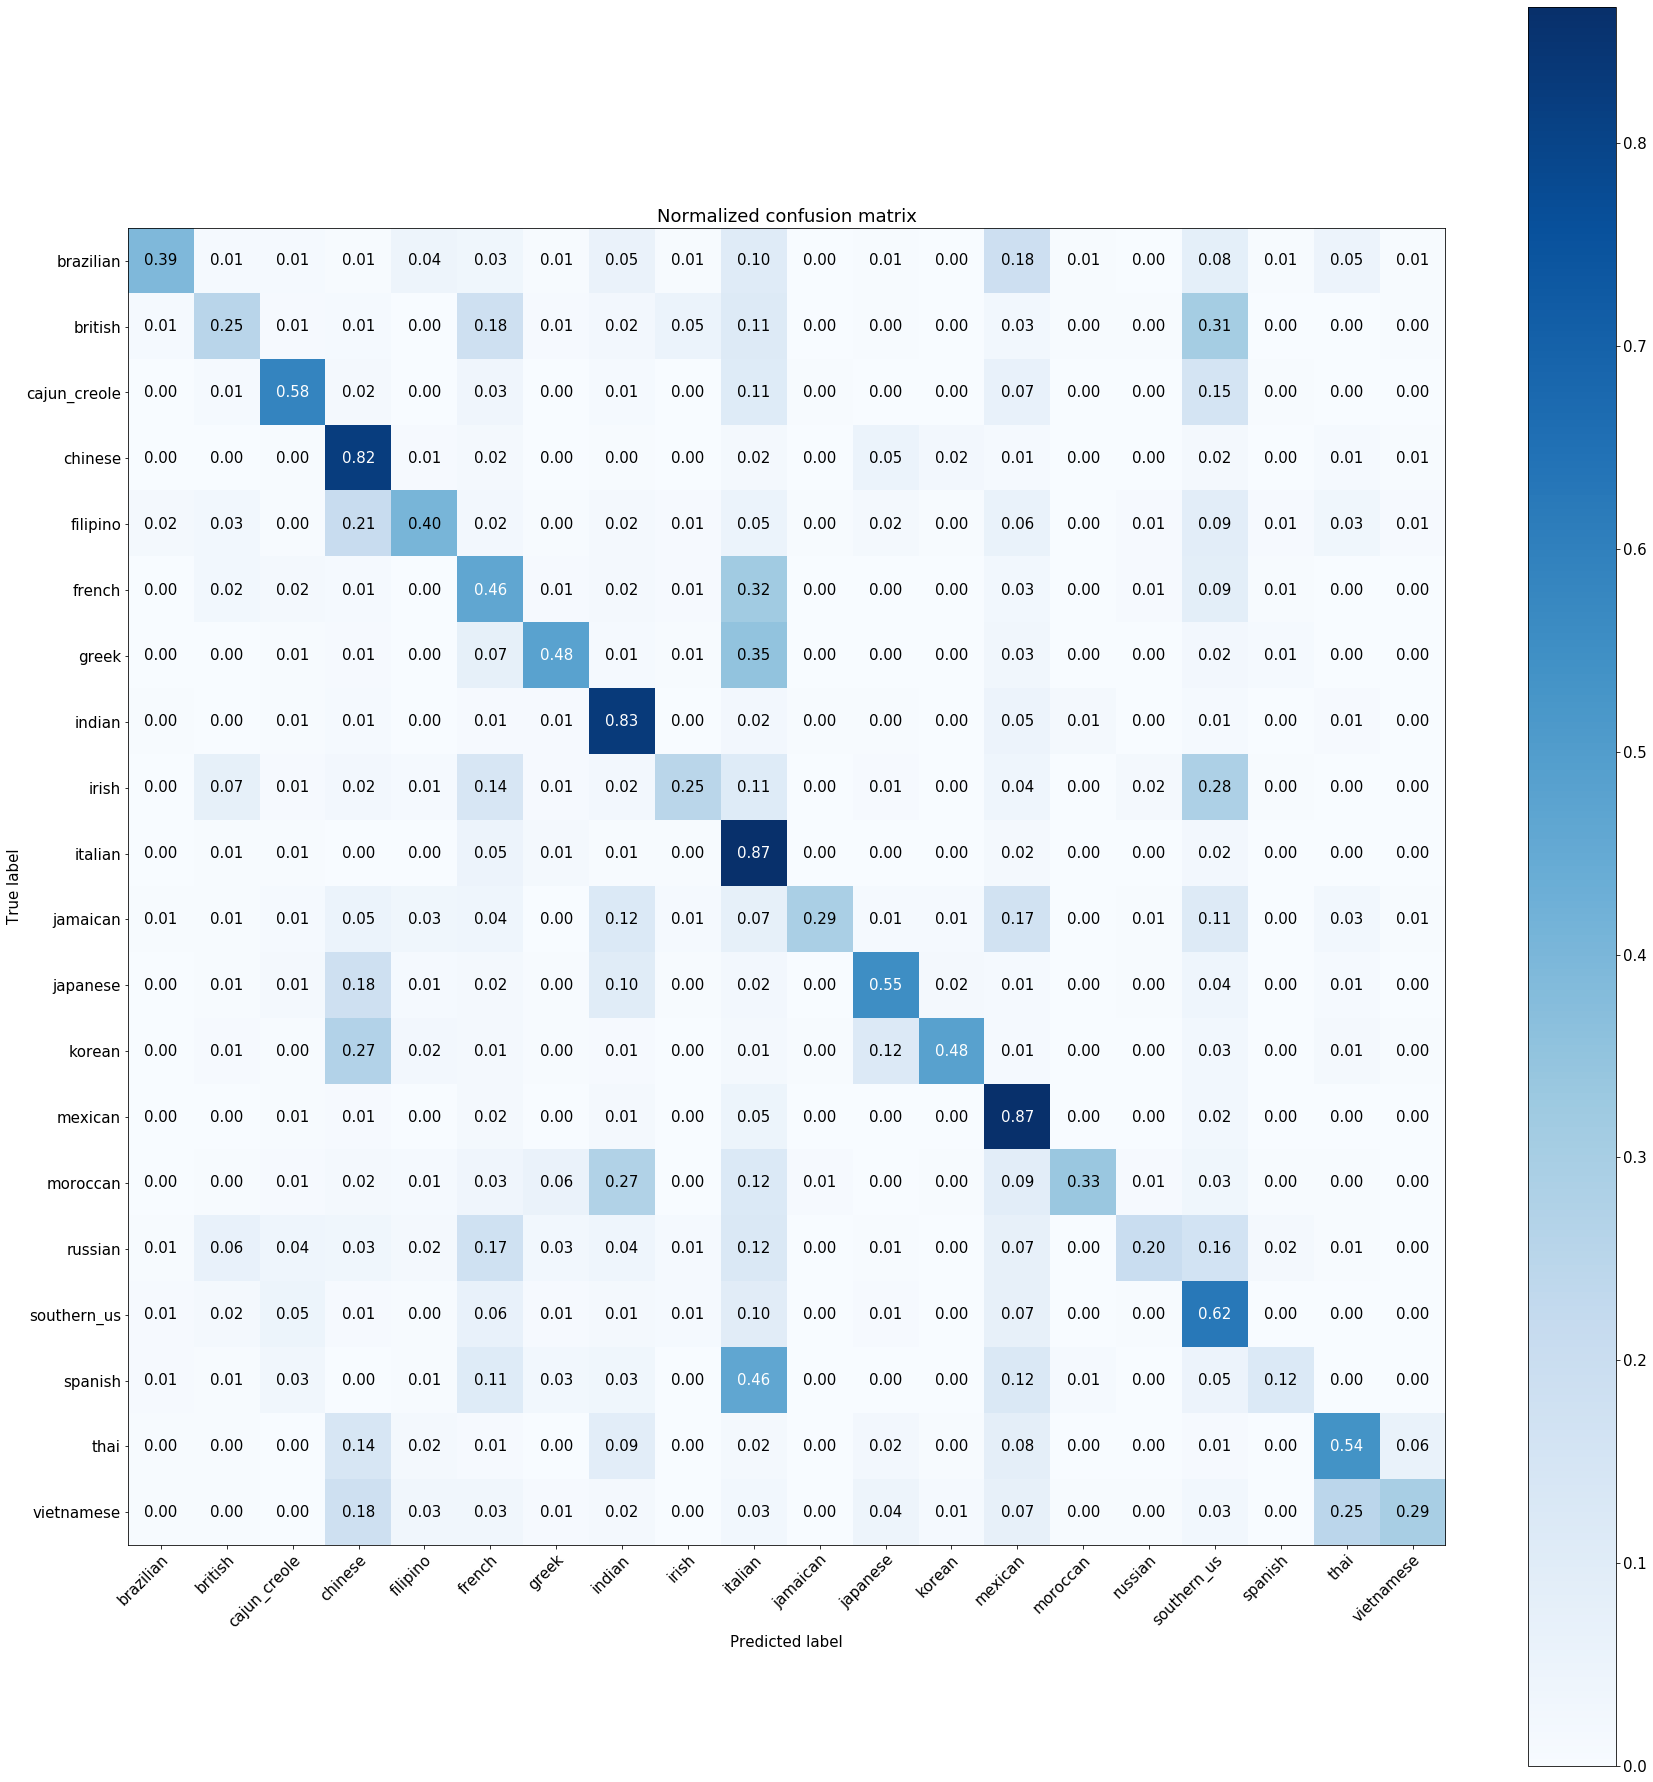

In [20]:
plot_confusion_matrix(y_test, y_pred, classes=le.classes_, normalize=True,
                      title='Normalized confusion matrix')

plt.savefig('rf_confusion.jpg')

## 3. Investigsat what are the common ingredients that create the misclassification

In [21]:
def find_common_ingredient(cuisine1, cuisine2, y, X_dummy_var):
    y = np.asarray(y)
    index1 = np.where(y==cuisine1)
    data1 = X_dummy_var[index1]
    count_ingredients = np.sum(data1,axis = 0)
    
    index2 = np.where(y==cuisine2)
    data2 = X_dummy_var[index2]
    count_ingredients2 = np.sum(data2,axis = 0)
    
    command_ingredients = np.where(count_ingredients&count_ingredients2 != 0)
    print (cuisine1,' and ', cuisine2, ' has', np.shape(command_ingredients)[1], 'common ingredients')

In [22]:
find_common_ingredient('brazilian', 'italian', raw_cuisines, X_dummy_var)

brazilian  and  italian  has 397 common ingredients


In [23]:
find_common_ingredient('brazilian', 'chinese', raw_cuisines, X_dummy_var)

brazilian  and  chinese  has 339 common ingredients


### Insight: 
Brazilian often  misclassified as italian, but not as Chinese, however, they both have similar number of common ingredients. This means that the common ingredients are not the key for the misclassification, it is the combination of ingredients.